In [4]:
import tensorflow as tf

### Definition

In [5]:
a = tf.constant(1.0)
b = tf.constant(2.0)
result = tf.add(a,b)

### Execution

In [6]:
with tf.Session() as session:
    print(session.run(result))

3.0


## Variables

Variables are defined by a:
- name
- type
- shape
- initialization procedure

### example

In [7]:
v = tf.get_variable("name",dtype=tf.float32,shape=[2,2],
                   initializer=tf.random_normal_initializer(stddev=0.5))

In [8]:
with tf.Session() as session:
    print(session.run(tf.global_variables_initializer()))
    print(session.run(v))

None
[[-0.6419687  -0.3186164 ]
 [ 0.2469056   0.10908391]]


### placeholder
Use placeholders and feed dictionaries to inject data in the graph at execution time. Using placeholders puts the onus on you to manage the data:
- TF expects a dictionary of numpy arrays for each call to session.run()
- The rest is up to you: load, pre-process, batch, queue, etc.
- Very flexible, but can be somewhat labour intensive
- TF offers additional built-in functionalities for working with data(e.g. tf.data)

#### example

In [9]:
a = tf.placeholder(tf.float32,[])
b = tf.constant(1.0)
c = a + b

with tf.Session() as session:
    print(session.run(c, feed_dict={a:3.0}))
    print(session.run(c, feed_dict={a:4.0}))

4.0
5.0


## Linear Regression 
#### data

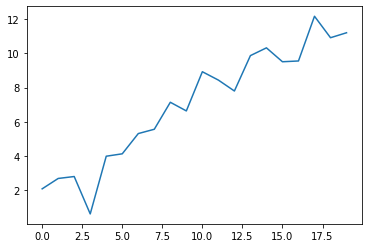

In [12]:
import numpy
from matplotlib import pyplot 
num_samples, w, b=20, 0.5, 2
xs = numpy.asarray(range(num_samples))
ys = numpy.asarray([
    x * w + b +numpy.random.normal()
    for x in range(num_samples)
])
pyplot.plot(xs,ys)

#### model

In [13]:
class Linear(object):
    def __init__(self):
        self.w = tf.get_variable(
            "w", dtype=tf.float32, shape=[], initializer=tf.zeros_initializer())
        self.b = tf.get_variable(
            "b", dtype=tf.float32, shape=[], initializer=tf.zeros_initializer())

    def __call__(self,x):
        return self.w * x + self.b

#### closed form

We can find the solution to the linear regression problem directly in closed form:

In [14]:
xtf = tf.placeholder(tf.float32, [num_samples], "xs")
ytf = tf.placeholder(tf.float32, [num_samples], "ys")
model = Linear()
model_output = model(xtf)

In [15]:
cov = tf.reduce_sum((xtf - tf.reduce_mean(xtf)) * (ytf - tf.reduce_mean(ytf)))
var = tf.reduce_sum(tf.square(xtf - tf.reduce_mean(xtf)))
w_hat = cov/var
b_hat = tf.reduce_mean(ytf) - w_hat * tf.reduce_mean(xtf)

In [16]:
solve_w = model.w.assign(w_hat)
solve_b = model.b.assign(tf.reduce_mean(ytf)-w_hat*tf.reduce_mean(xtf))

In [17]:
with tf.train.MonitoredSession() as sess:
    sess.run([solve_w, solve_b], feed_dict={xtf:xs, ytf:ys})
    preds = sess.run(model_output, feed_dict={xtf: xs, ytf:ys})

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


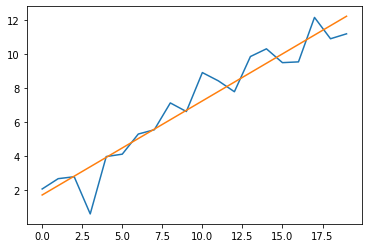

In [19]:
pyplot.plot(xs,ys)
pyplot.plot(xs, preds)

#### Gradient Descent

In [36]:
loss = tf.losses.mean_squared_error(ytf, model_output)
grads = tf.gradients(loss, [model.w,model.b])

learning_rate = tf.constant(0.001)

update_w = tf.assign(model.w, model.w - learning_rate * grads[0])
update_b = tf.assign(model.b, model.b - learning_rate * grads[1])
update = tf.group(update_w,update_b)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


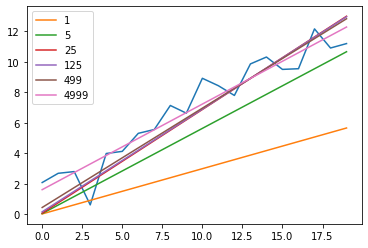

In [37]:
pyplot.plot(xs,ys)
feed_dict = {xtf: xs, ytf: ys}

with tf.train.MonitoredSession() as sess:
    for i in range(5000):
        sess.run(update, feed_dict=feed_dict)
        if i in [1,5,25,125,499,4999]:
            preds = sess.run(model_output, feed_dict=feed_dict)
            pyplot.plot(xs,preds,label=str(i))

pyplot.legend()

#### TensorFlow Optmiziers

In [38]:
loss = tf.losses.mean_squared_error(ytf, model_output)
update = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


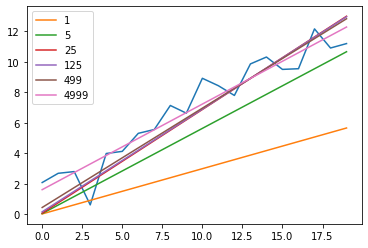

In [39]:
pyplot.plot(xs,ys)
feed_dict = {xtf: xs, ytf: ys}

with tf.train.MonitoredSession() as sess:
    for i in range(5000):
        sess.run(update, feed_dict=feed_dict)
        if i in [1,5,25,125,499,4999]:
            preds = sess.run(model_output, feed_dict=feed_dict)
            pyplot.plot(xs,preds,label=str(i))

pyplot.legend()

## Dynamic Unrolling - Core
In Deep Learning and Reinforcement Learning it is common to have to apply the same transformation (core) recursively to some state, in order to accumulate some sequence of outputs along the way. This is important for:
- Time series prediction
- Sequence to sequence models
- Take decisions in partially observable domains

#### Example: Fibonacci

In [41]:
class fibonacci_core(object):
    
    def __init__(self):
        self.output_size = 1
        self.state_size = tf.TensorShape([1,1])
    
    def __call__(self, input, state):
        return state[0]+state[1], (state[1],state[0]+state[1])
    
    def zero_state(self, batch_size, dtype):
        return (tf.zeros((batch_size,1),dtype=dtype),
               tf.ones((batch_size,1),dtype=dtype))
    
    def initial_state(self, batch_size, dtype):
        return zero_state(self, batch_size, dtype)

In [45]:
inputs = tf.reshape(tf.range(10), [10,1,1])

fib_seq = tf.nn.dynamic_rnn(
    cell=fibonacci_core(),
    inputs=inputs,
    dtype=tf.float32,
    time_major=True)

with tf.train.MonitoredSession() as sess:
    print(sess.run(fib_seq))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
(array([[[ 1.]],

       [[ 2.]],

       [[ 3.]],

       [[ 5.]],

       [[ 8.]],

       [[13.]],

       [[21.]],

       [[34.]],

       [[55.]],

       [[89.]]], dtype=float32), (array([[55.]], dtype=float32), array([[89.]], dtype=float32)))


## Execution on GPU

In [47]:
with tf.device("/cpu:0"):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2,3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3,2], name='b')
    
with tf.device("/gpu:0"):
    c = tf.matmul(a,b)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    print(sess.run(c))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



InvalidArgumentError: Cannot assign a device for operation MatMul_1: node MatMul_1 (defined at /usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748)  was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:XLA_CPU:0 ]. Make sure the device specification refers to a valid device. The requested device appears to be a GPU, but CUDA is not enabled.
	 [[MatMul_1]]